<a href="https://colab.research.google.com/github/praveen-raj-m/Feature-Selection-on-Life-Expectancy-Data./blob/main/Model_Selection_and_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing and Importing Required Modules**

In [ ]:
!pip install featurewiz
!pip install delayed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
import matplotlib as mpl
import seaborn as sns
import delayed
from featurewiz import featurewiz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, linear_model, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Imported featurewiz: advanced feature engg and selection library. Version=0.0.35
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


## **Reading the Dataset**

Link - https://www.kaggle.com/kumarajarshi/life-expectancy-who

In [ ]:
df = pd.read_csv('Life Expectancy Data.csv')

In [ ]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
orig_cols = list(df.columns)
new_cols = []
for col in orig_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
df.columns = new_cols

In [ ]:
df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

## **Handling Null Values**

In [ ]:
mort_5_percentile = np.percentile(df.adult_mortality.dropna(), 5)
df.adult_mortality = df.apply(lambda x: np.nan if x.adult_mortality < mort_5_percentile else x.adult_mortality, axis=1)
df.infant_deaths = df.infant_deaths.replace(0, np.nan)
df.bmi = df.apply(lambda x: np.nan if (x.bmi < 10 or x.bmi > 50) else x.bmi, axis=1)
df['under-five_deaths'] = df['under-five_deaths'].replace(0, np.nan)

In [ ]:
def nulls_breakdown(df=df):
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))

In [ ]:
nulls_breakdown()

[iloc = 3] life_expectancy has 10 null values: 0.34% null
[iloc = 4] adult_mortality has 155 null values: 5.28% null
[iloc = 5] infant_deaths has 848 null values: 28.86% null
[iloc = 6] alcohol has 194 null values: 6.6% null
[iloc = 8] hepatitis_b has 553 null values: 18.82% null
[iloc = 10] bmi has 1456 null values: 49.56% null
[iloc = 11] under-five_deaths has 785 null values: 26.72% null
[iloc = 12] polio has 19 null values: 0.65% null
[iloc = 13] total_expenditure has 226 null values: 7.69% null
[iloc = 14] diphtheria has 19 null values: 0.65% null
[iloc = 16] gdp has 448 null values: 15.25% null
[iloc = 17] population has 652 null values: 22.19% null
[iloc = 18] thinness_10-19_years has 34 null values: 1.16% null
[iloc = 19] thinness_5-9_years has 34 null values: 1.16% null
[iloc = 20] income_composition_of_resources has 167 null values: 5.68% null
[iloc = 21] schooling has 163 null values: 5.55% null
Out of 22 total columns, 16 contain null values; 72.73% columns contain null val

In [ ]:
df.drop(columns='bmi', inplace=True)

In [ ]:
imputed_data = []
for year in list(df.year.unique()):
    year_data = df[df.year == year].copy()
    for col in list(year_data.columns)[3:]:
        year_data[col] = year_data[col].fillna(year_data[col].dropna().mean()).copy()
    imputed_data.append(year_data)
df = pd.concat(imputed_data).copy()

In [ ]:
nulls_breakdown(df)

Out of 21 total columns, 0 contain null values; 0.0% columns contain null values.


## **Handling Outliers**

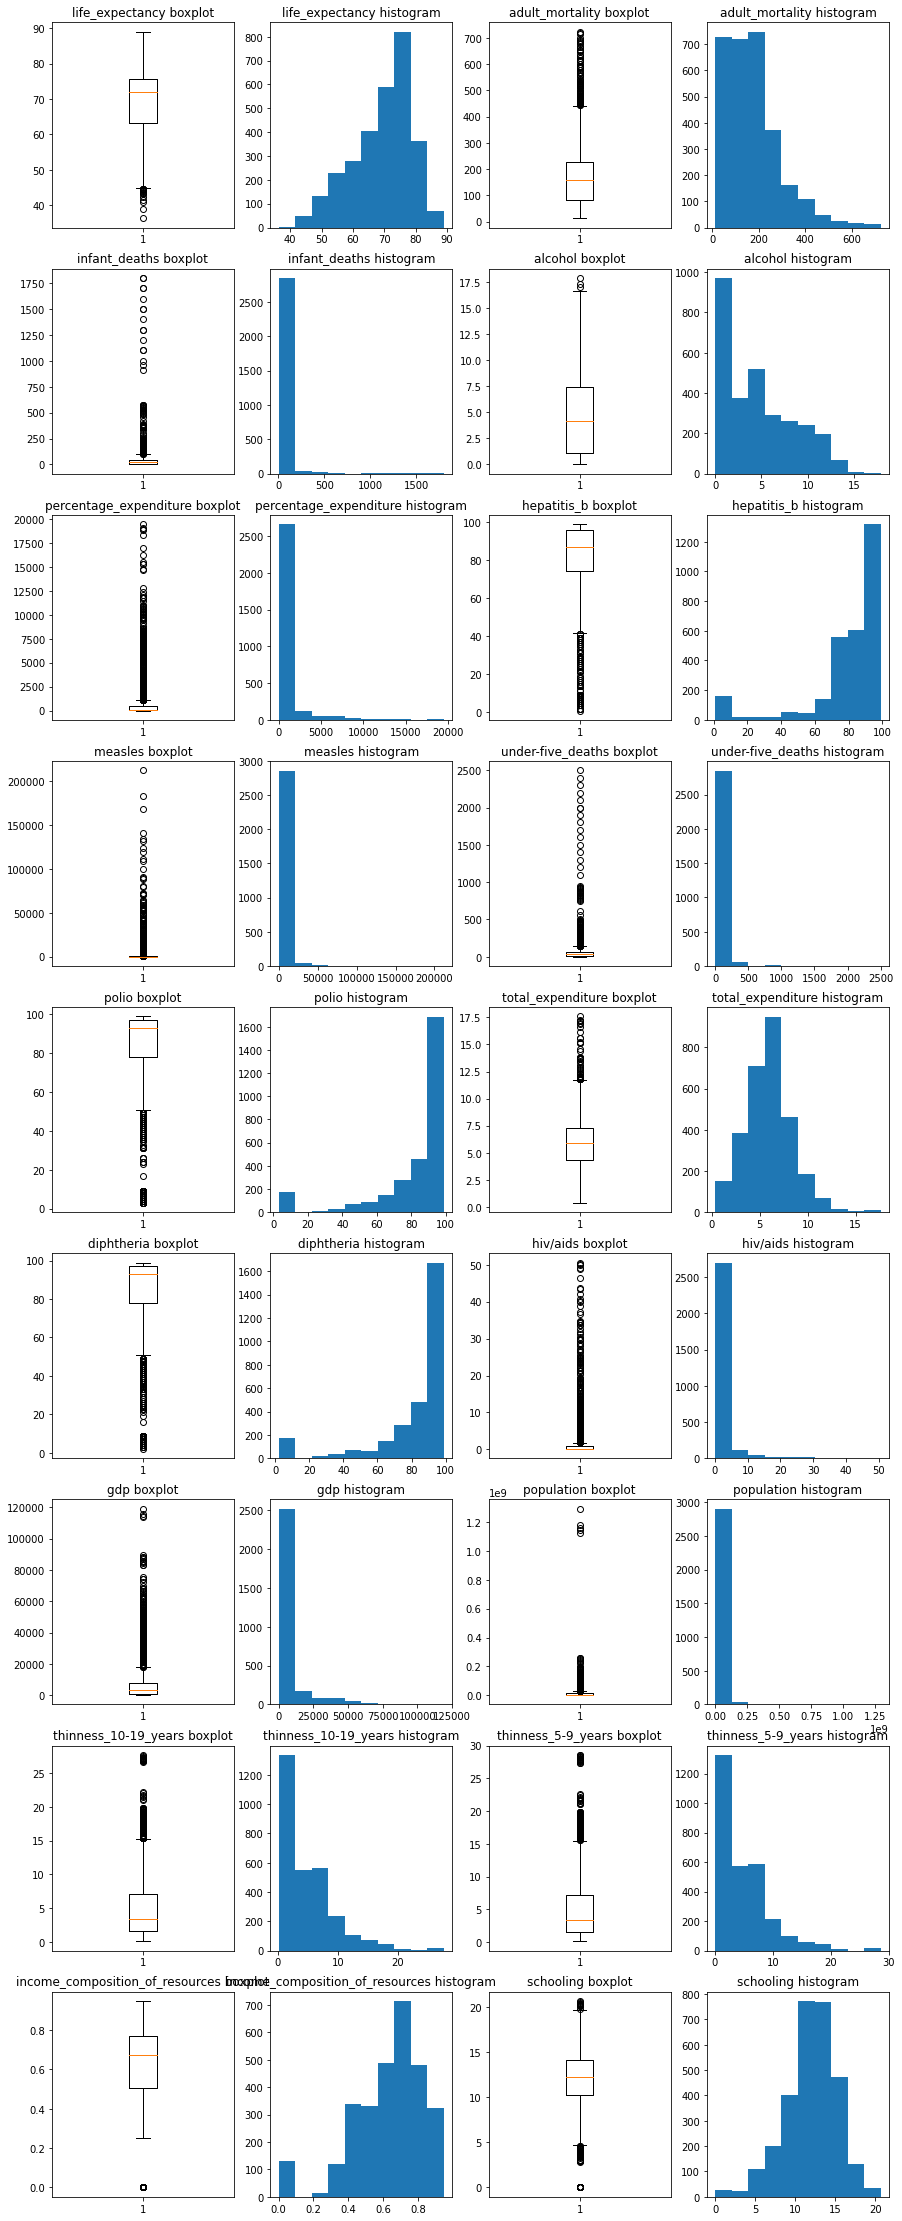

In [ ]:
cont_vars = list(df.columns)[3:]
def outliers_visual(data):
    plt.figure(figsize=(15, 40))
    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
        plt.subplot(9, 4, i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
    plt.show()
outliers_visual(df)

In [ ]:
def outlier_count(col, data=df):
    print(15*'-' + col + 15*'-')
    q75, q25 = np.percentile(data[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    print('Number of outliers: {}'.format(outlier_count))
    print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [ ]:
for col in cont_vars:
    outlier_count(col)

---------------life_expectancy---------------
Number of outliers: 17
Percent of data that is outlier: 0.58%
---------------adult_mortality---------------
Number of outliers: 97
Percent of data that is outlier: 3.3%
---------------infant_deaths---------------
Number of outliers: 135
Percent of data that is outlier: 4.59%
---------------alcohol---------------
Number of outliers: 3
Percent of data that is outlier: 0.1%
---------------percentage_expenditure---------------
Number of outliers: 389
Percent of data that is outlier: 13.24%
---------------hepatitis_b---------------
Number of outliers: 222
Percent of data that is outlier: 7.56%
---------------measles---------------
Number of outliers: 542
Percent of data that is outlier: 18.45%
---------------under-five_deaths---------------
Number of outliers: 142
Percent of data that is outlier: 4.83%
---------------polio---------------
Number of outliers: 279
Percent of data that is outlier: 9.5%
---------------total_expenditure---------------

In [ ]:
def test_wins(col, lower_limit=0, upper_limit=0, show_plot=True):
    wins_data = winsorize(df[col], limits=(lower_limit, upper_limit))
    wins_dict[col] = wins_data
    if show_plot == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.boxplot(df[col])
        plt.title('original {}'.format(col))
        plt.subplot(122)
        plt.boxplot(wins_data)
        plt.title('wins=({},{}) {}'.format(lower_limit, upper_limit, col))
        plt.show()

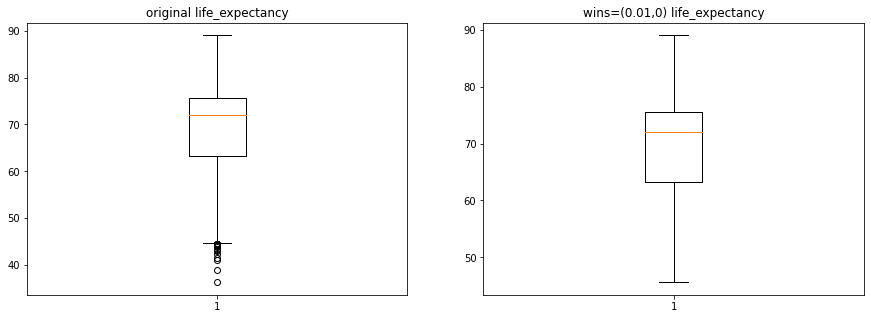

In [ ]:
wins_dict = {}
test_wins(cont_vars[0], lower_limit=.01, show_plot=True)
test_wins(cont_vars[1], upper_limit=.04, show_plot=False)
test_wins(cont_vars[2], upper_limit=.05, show_plot=False)
test_wins(cont_vars[3], upper_limit=.0025, show_plot=False)
test_wins(cont_vars[4], upper_limit=.135, show_plot=False)
test_wins(cont_vars[5], lower_limit=.1, show_plot=False)
test_wins(cont_vars[6], upper_limit=.19, show_plot=False)
test_wins(cont_vars[7], upper_limit=.05, show_plot=False)
test_wins(cont_vars[8], lower_limit=.1, show_plot=False)
test_wins(cont_vars[9], upper_limit=.02, show_plot=False)
test_wins(cont_vars[10], lower_limit=.105, show_plot=False)
test_wins(cont_vars[11], upper_limit=.185, show_plot=False)
test_wins(cont_vars[12], upper_limit=.105, show_plot=False)
test_wins(cont_vars[13], upper_limit=.07, show_plot=False)
test_wins(cont_vars[14], upper_limit=.035, show_plot=False)
test_wins(cont_vars[15], upper_limit=.035, show_plot=False)
test_wins(cont_vars[16], lower_limit=.05, show_plot=False)
test_wins(cont_vars[17], lower_limit=.025, upper_limit=.005, show_plot=False)

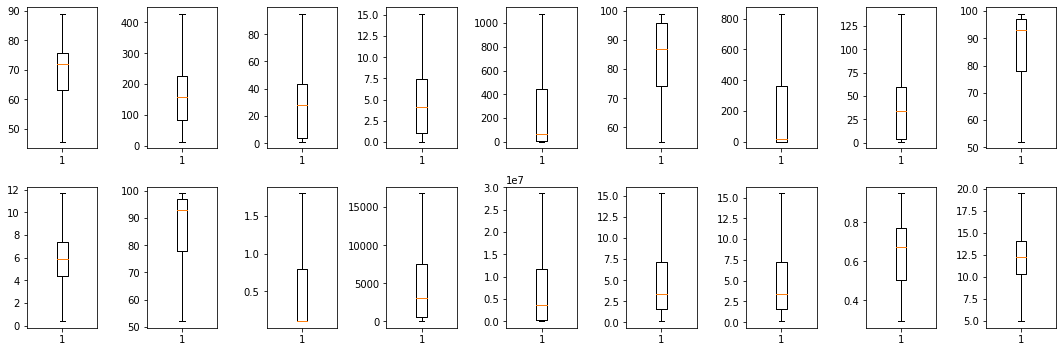

In [ ]:
plt.figure(figsize=(15,5))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(2, 9, i)
    plt.boxplot(wins_dict[col])
plt.tight_layout()
plt.show()

In [ ]:
wins_df = df.iloc[:, 0:3]
for col in cont_vars:
    wins_df[col] = wins_dict[col]

In [ ]:
wins_df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.248795,169.191269,28.607323,4.640667,281.501093,83.671293,220.691287,38.640545,85.514684,5.972192,85.469564,0.526991,5033.943592,7.508368e+06,4.703351,4.720470,0.640659,12.049874
std,4.613841,9.462136,107.646049,25.699534,3.910036,384.161450,13.848933,329.192321,37.732345,15.270927,2.302224,15.217611,0.675962,5408.511820,8.646842e+06,3.925702,3.964268,0.171622,3.085673
min,2000.000000,45.600000,13.000000,1.000000,0.010000,0.000000,55.000000,0.000000,1.000000,52.000000,0.370000,52.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.291000,4.900000
25%,2004.000000,63.200000,84.000000,4.000000,1.092500,4.685343,74.099237,0.000000,4.000000,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.000000,157.000000,28.000000,4.140000,64.912906,87.000000,17.000000,34.000000,93.000000,5.910000,93.000000,0.100000,3116.561755,3.675929e+06,3.400000,3.400000,0.673000,12.300000
75%,2012.000000,75.600000,227.000000,43.766917,7.390000,441.534144,96.000000,360.250000,60.014815,97.000000,7.330000,97.000000,0.800000,7464.487887,1.181332e+07,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,428.000000,95.000000,15.140000,1077.712092,99.000000,831.000000,138.000000,99.000000,11.660000,99.000000,1.800000,16784.346160,2.865628e+07,15.300000,15.500000,0.948000,19.500000


In [ ]:
wins_df.describe(include='O')

,country,status
count,2938,2938
unique,193,2
top,Colombia,Developing
freq,16,2426


##**Visualization of Dataset After Pre-Processing**

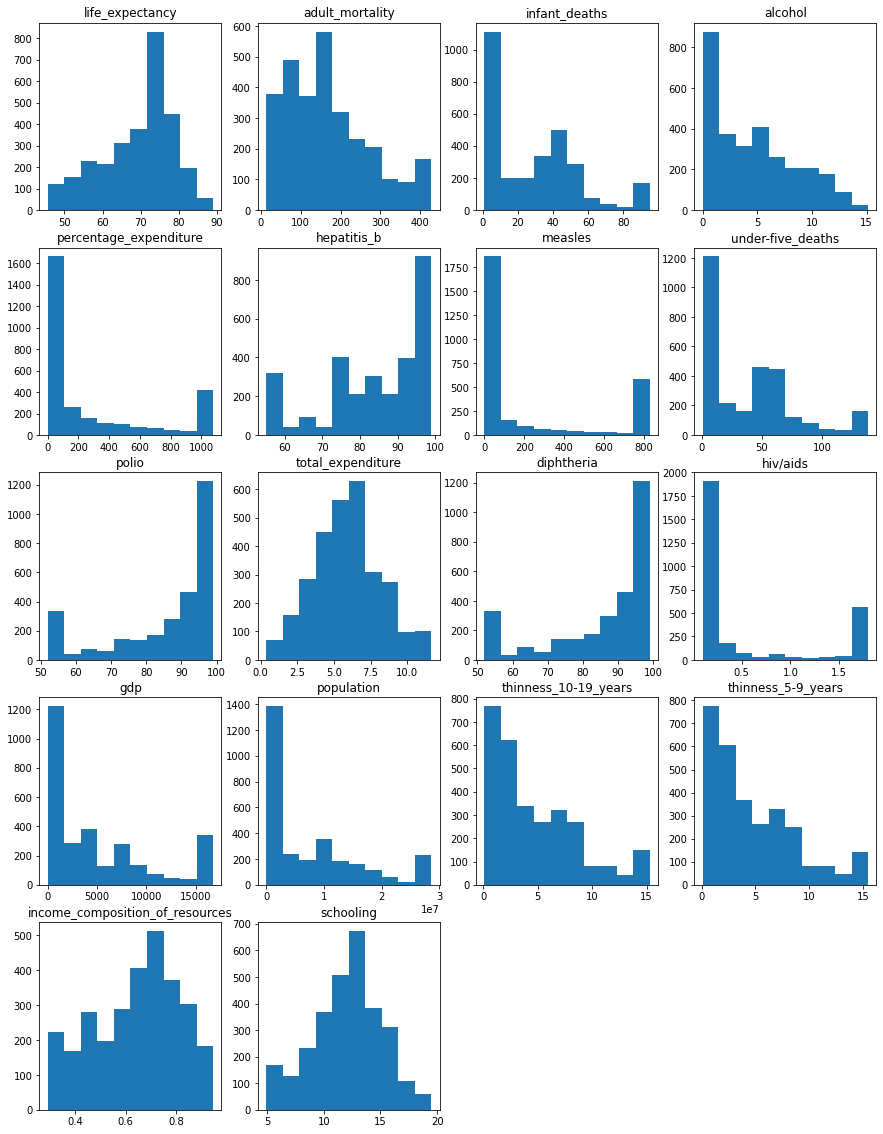

In [ ]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(5, 4, i)
    plt.hist(wins_df[col])
    plt.title(col)

## **Developed Countries vs Developing Counrties**

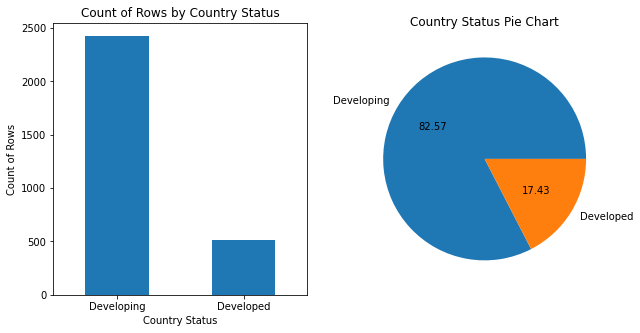

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
wins_df.status.value_counts().plot(kind='bar')
plt.title('Count of Rows by Country Status')
plt.xlabel('Country Status')
plt.ylabel('Count of Rows')
plt.xticks(rotation=0)

plt.subplot(122)
wins_df.status.value_counts().plot(kind='pie', autopct='%.2f')
plt.ylabel('')
plt.title('Country Status Pie Chart')

plt.show()

## **Heat Map of All Features**

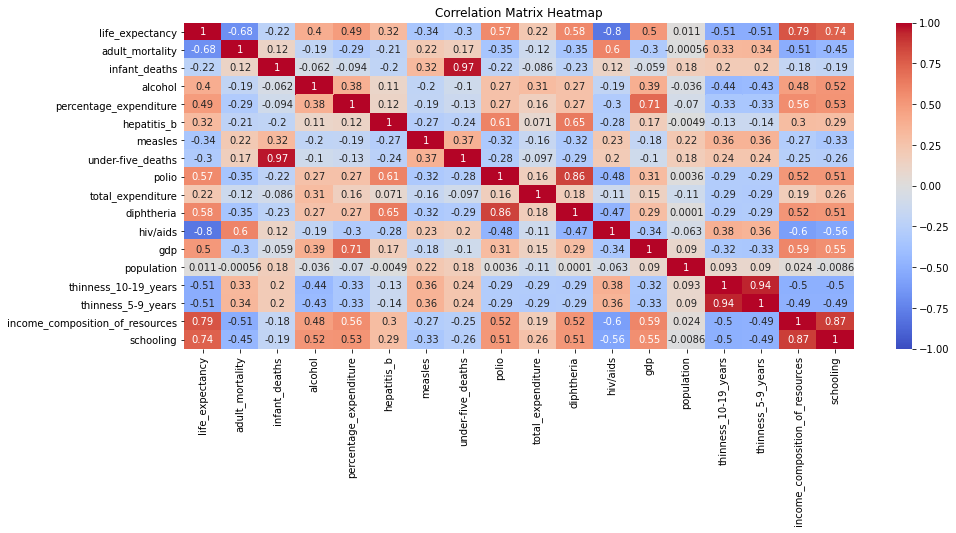

In [ ]:
#mask = np.triu(wins_df[cont_vars].corr())
plt.figure(figsize=(15,6))
sns.heatmap(wins_df[cont_vars].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

##**Life Expectancy Trend**

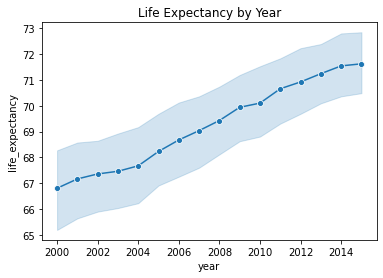

In [ ]:
sns.lineplot('year', 'life_expectancy', data=wins_df, marker='o')
plt.title('Life Expectancy by Year')
plt.show()

In [ ]:
X= wins_df.drop(['life_expectancy'],axis=1)
y=wins_df['life_expectancy']
Xboruto=wins_df.drop(['life_expectancy','country','year'],axis=1)

##**Life Expectancy Trends of Developed and Developing Countries**

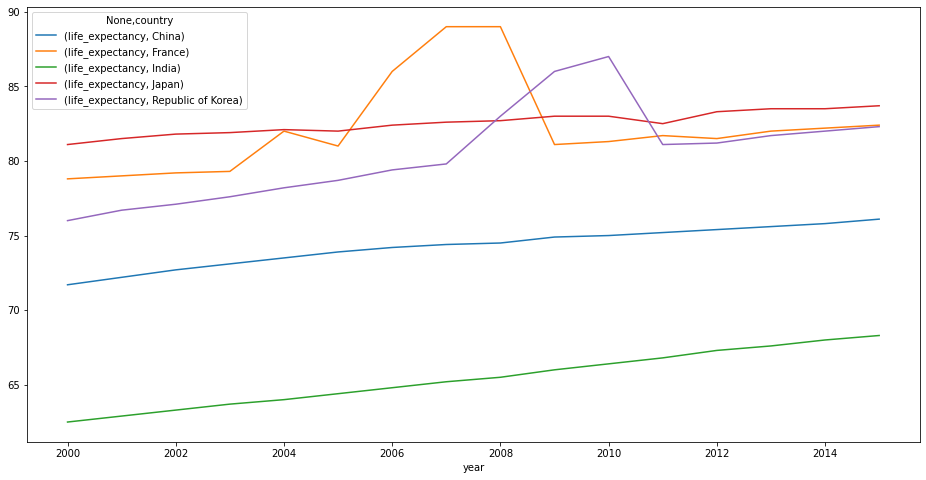

In [ ]:
c = ['India','China','France','Japan','Republic of Korea']
j = [wins_df.loc[wins_df.country==y, :] for y in c]
j = np.array(j)
j = j.transpose(1,0,2).reshape(80,-1)
data = pd.DataFrame(j,columns=wins_df.columns)
cols = ['life_expectancy','year']
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')
piv = pd.pivot_table(data, index=['year'],columns=['country'], values=['life_expectancy'])
piv.plot(figsize=(16,8))

## **Impact of Income on Life Expectancy**

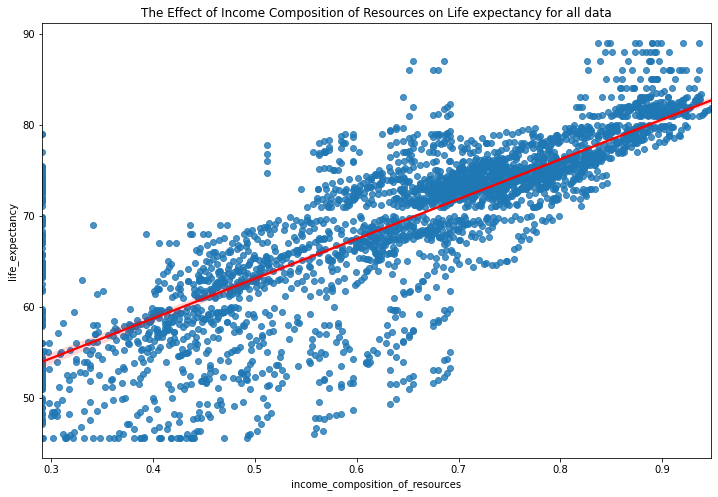

In [ ]:
plt.rcParams["figure.figsize"]=(12,8)
sns.regplot(x=wins_df['income_composition_of_resources'], y=wins_df['life_expectancy'], data=wins_df, line_kws={"color": "red"}).set_title("The Effect of Income Composition of Resources on Life expectancy for all data");

## **Impact of Education on Life Expectancy**

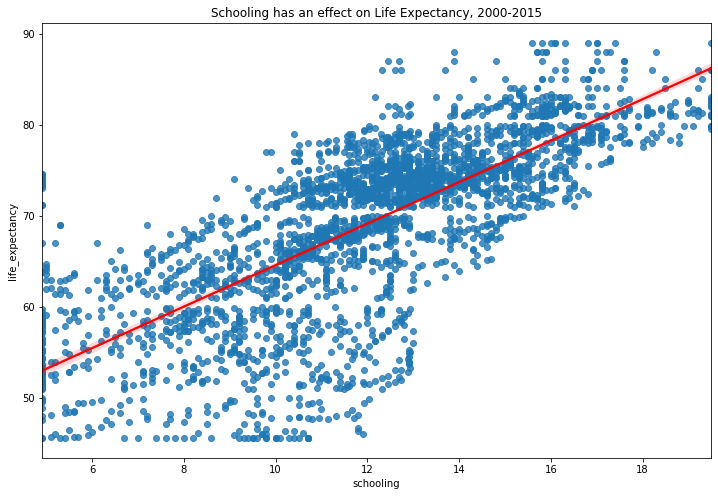

In [ ]:
plt.rcParams["figure.figsize"]=(12,8)
sns.regplot(x=wins_df['schooling'], y=wins_df['life_expectancy'], data=wins_df,line_kws={"color": "red"}).set_title("Schooling has an effect on Life Expectancy, 2000-2015");

## **Feature Extraction Using FeatureWiz**

Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Shape of your Data Set loaded: (2938, 21)
File not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    20 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
Shape of your Data Set loaded: (2938, 21)
Number of processors on machine = 1
    GPU active on this device
    Running XGBoost using GPU parameters
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    20 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
Processing year column for date time features....
#### Single_Label Regression Feature Selection Started ####
Searching for highly correlated variables from 17 variables using SULOV method
#####  

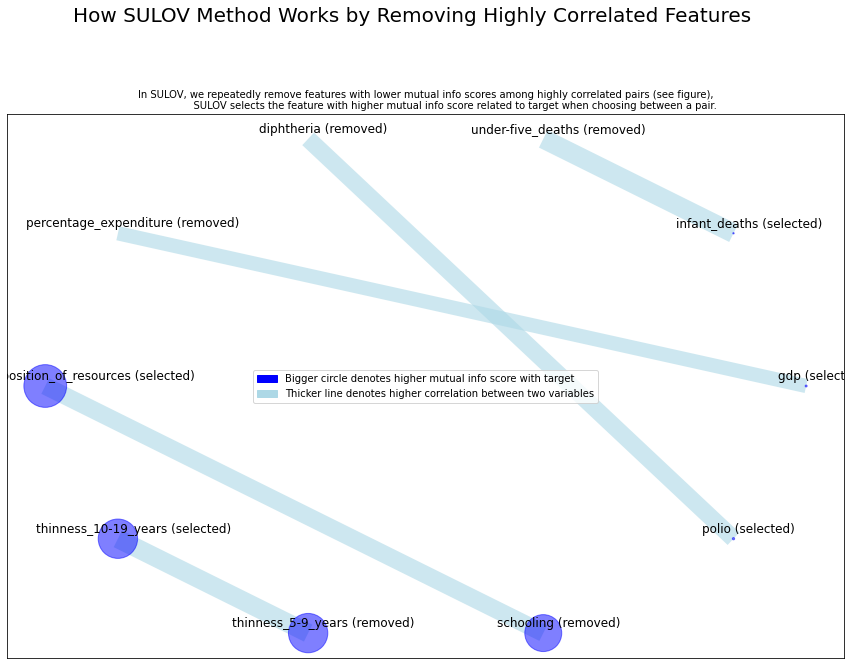

    Adding 1 categorical variables to reduced numeric variables  of 12
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 13 
    Finding Important Features using Boosted Trees algorithm...
        using 13 variables...
        using 10 variables...
        using 7 variables...
        using 4 variables...
        using 1 variables...
Selected 12 important features from your dataset
    Time taken (in seconds) = 2
Returning list of 12 important features and dataframe.


In [ ]:
target = ['life_expectancy']
features = featurewiz(wins_df, target, corr_limit=0.70,verbose=2)

In [ ]:
features

(['hiv/aids',
  'adult_mortality',
  'income_composition_of_resources',
  'status',
  'thinness_10-19_years',
  'polio',
  'infant_deaths',
  'alcohol',
  'total_expenditure',
  'population',
  'gdp',
  'measles'],
       hiv/aids  adult_mortality  ...  measles  life_expectancy
 0          0.1            263.0  ...      831             65.0
 16         0.1             74.0  ...        0             77.8
 32         0.1             19.0  ...       63             75.6
 48         1.8            335.0  ...      118             52.4
 64         0.2             13.0  ...        0             76.4
 ...        ...              ...  ...      ...              ...
 2873       0.1            168.0  ...       22             72.5
 2889       0.1            139.0  ...      831             73.4
 2905       0.1            252.0  ...        0             68.0
 2921       1.8            428.0  ...      831             45.6
 2937       1.8            428.0  ...      831             46.0
 
 [2938 rows x 1

In [ ]:
X=wins_df[['hiv/aids',
  'adult_mortality',
  'income_composition_of_resources',
  'thinness_10-19_years',
  'status',
  'polio',
  'infant_deaths',
  'alcohol',
  'gdp',
  'total_expenditure',
  'measles',
  'year',
  'population']]
y=wins_df['life_expectancy']



In [ ]:
le = LabelEncoder()  
X['status']= le.fit_transform(X['status'])
#X['Geography']= le.fit_transform(data['Geography'])

## **Train-Test Spilt**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  
# printing the shapes of the new X objects
print(X_train.shape)
print(X_test.shape)
  
# printing the shapes of the new y objects
print(y_train.shape)
print(y_test.shape)

(2350, 13)
(588, 13)
(2350,)
(588,)


## **Defining Function to Train Models and Plot Respective Graphs**

In [ ]:
def trainModel(modelName, Acc, Abs, Sqr,featureImp,t):
  modelName.fit(X_train, y_train)
  pred = modelName.predict(X_test)
  accuracy_score =  modelName.score(X_test,y_test)
  print("Accuracy = ",accuracy_score*100)
  Acc.append(accuracy_score*100)
  print("Mean Absolute Error = ", mean_absolute_error(y_test, pred))
  Abs.append(mean_absolute_error(y_test, pred))
  print("Mean Squared Error = ", mean_squared_error(y_test, pred))
  Sqr.append(mean_squared_error(y_test, pred))
  print("\n")

  fig = plt.figure(figsize=(18, 12))
  ax = fig.add_subplot(221)
  ax2 = fig.add_subplot(222)
  ax3 = fig.add_subplot(223)

  ax.set_title("Predicted vs Actual Value")
  ax.scatter(pred, y_test, edgecolors=(0, 0, 1))
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')


  ax2.scatter(modelName.predict(X_train), modelName.predict(X_train) - y_train,color = "green", s = 10, label = 'Train data')
  ax2.scatter(modelName.predict(X_test), modelName.predict(X_test) - y_test,color = "blue", s = 10, label = 'Test data')
  ax2.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
  ax2.legend(loc = 'upper right')
  ax2.set_title("Residual errors")


  if t==0:
    feat_importances = pd.Series(modelName.feature_importances_, index=X_train.columns)
    #feat_importances.nlargest(25).plot(kind='barh',figsize=(5,5))
    j = 0
    ax3.bar(X_train.columns, feat_importances,color='green', width = 0.4)
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.ylabel("Importance")
    plt.title("Importance of Features")
    for i in feat_importances:
      featureImp[j] = featureImp[j] + i
      j = j+1
  else:
    importance = modelName.coef_
    j = 0
    val = []
    for i,v in enumerate(importance):
      val.append(v)
    ax3.bar(X_train.columns, val ,color='green', width = 0.4)
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.ylabel("Importance")
    plt.title("Importance of Features")
    for i,v in enumerate(importance):
      featureImp[j] = featureImp[j] + v
      j = j+1
      #print(v)
  plt.show()
  print("\n\n")

## **Initializing Different Models and Calling Training Function**

In [ ]:
Linear_reg = linear_model.LinearRegression()
Random_forest = RandomForestRegressor(n_estimators = 100, random_state = 0)
DT_reg = DecisionTreeRegressor()
e_net = ElasticNet(alpha = 1)
lasso = Lasso(alpha = 1)
ridgeR = Ridge(alpha = 1)
Bayreg = linear_model.BayesianRidge()
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)

Random Forest Regressor
-----------------------
Accuracy =  96.4564339083955
Mean Absolute Error =  1.1997176870748276
Mean Squared Error =  2.9305082978763584




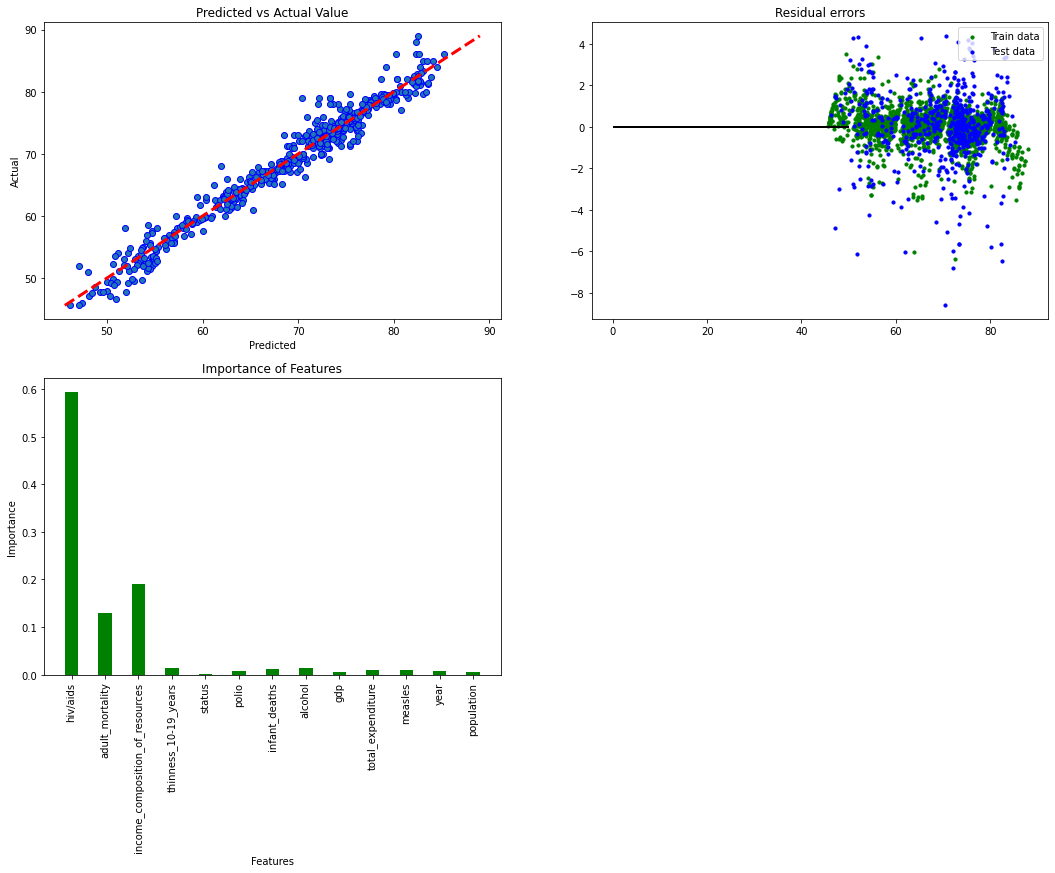




Decision Tree Regressor
-----------------------
Accuracy =  91.65066481546656
Mean Absolute Error =  1.5313873090219694
Mean Squared Error =  6.904851047648296




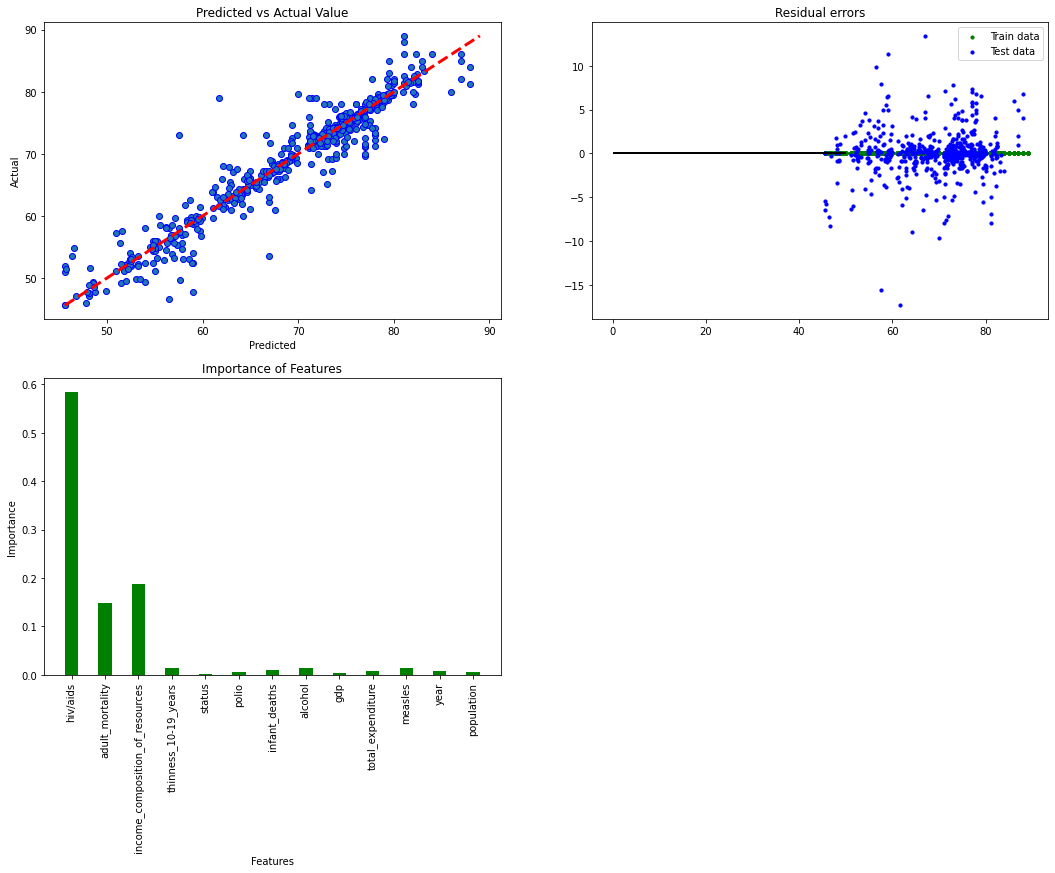




XGB Regressor
-------------
Accuracy =  88.27289864476344
Mean Absolute Error =  2.40360766785512
Mean Squared Error =  9.698243786952201




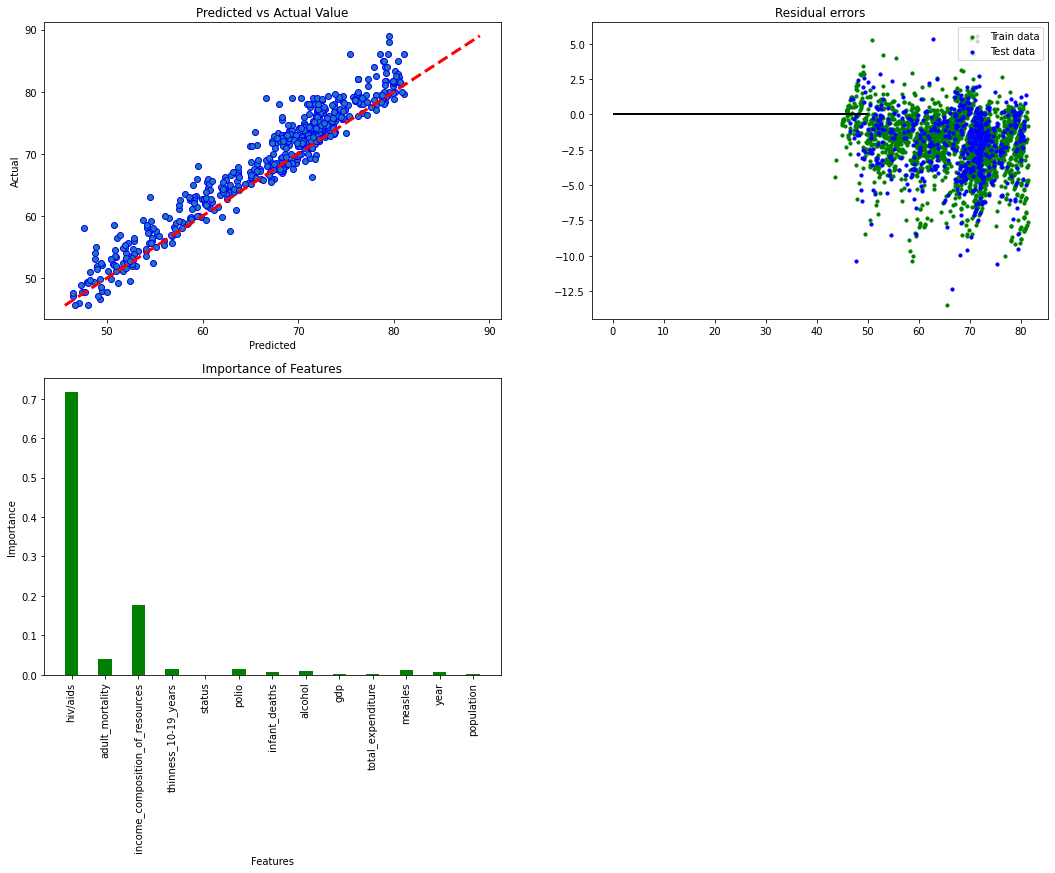




Lnear Regression
----------------
Accuracy =  84.43591862335
Mean Absolute Error =  2.7249536780988106
Mean Squared Error =  12.871403677543244




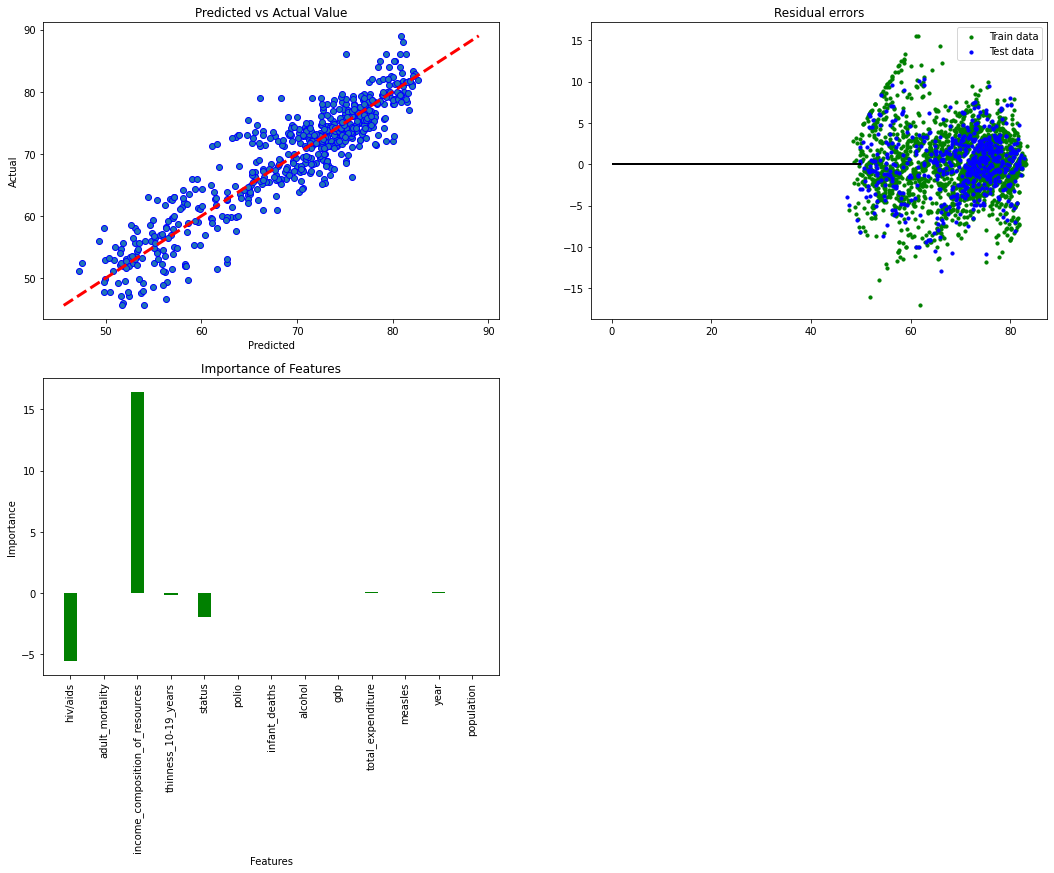




Lasso Regression
----------------
Accuracy =  79.17586976396616
Mean Absolute Error =  3.154159378629529
Mean Squared Error =  17.221433119968513




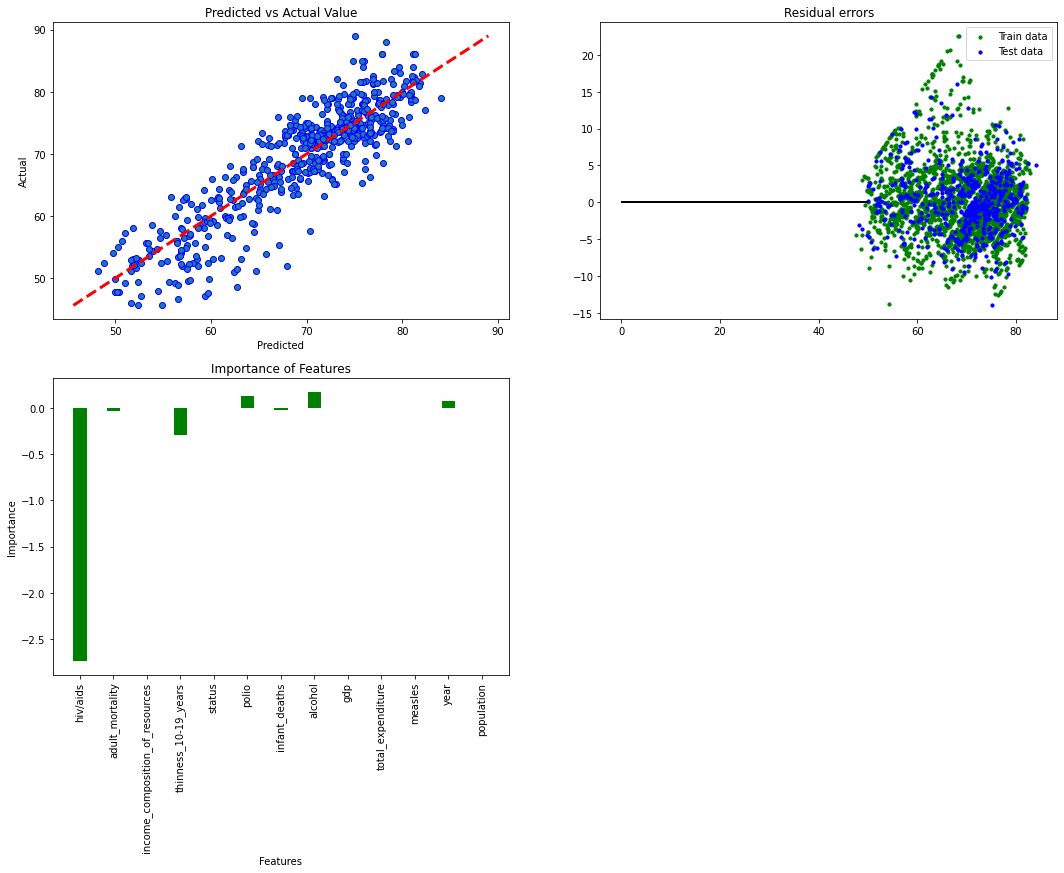




Elastic Net Regressor
---------------------
Accuracy =  77.00163774387644
Mean Absolute Error =  3.2912058750016864
Mean Squared Error =  19.019510201549465




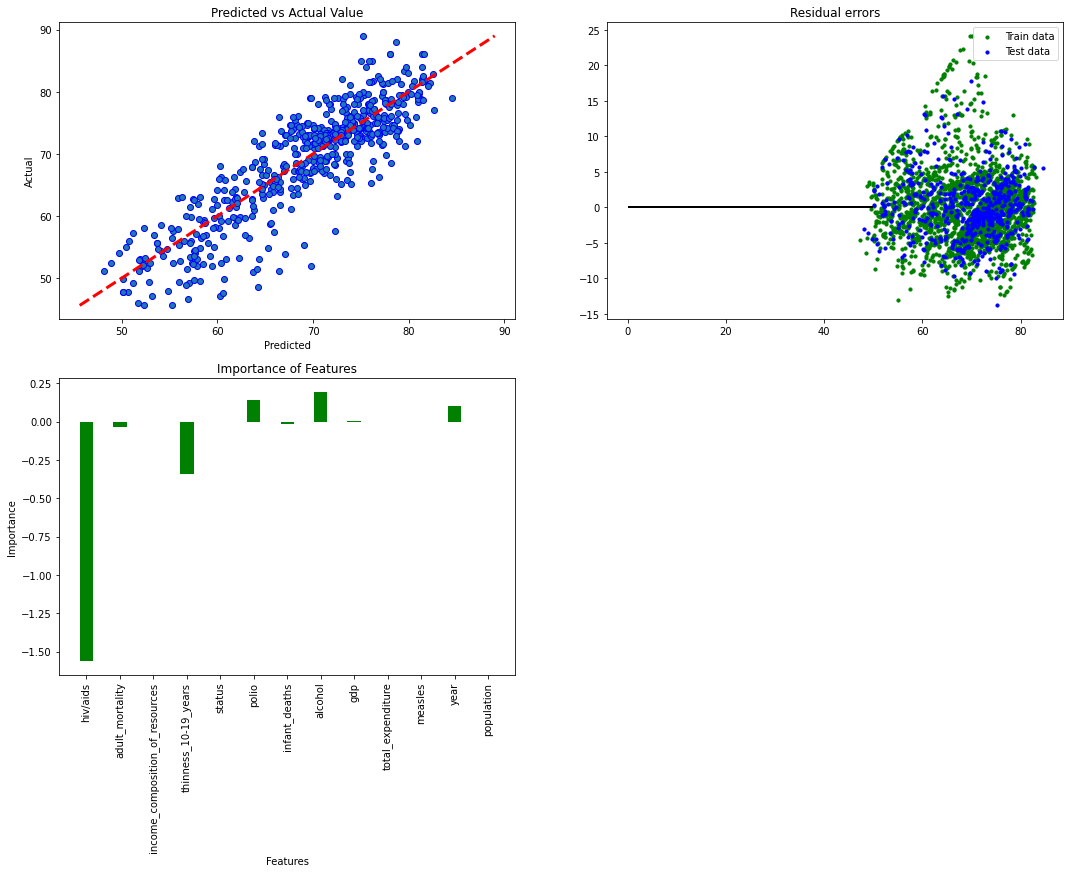




Ridge Regression
----------------
Accuracy =  84.48926305036937
Mean Absolute Error =  2.723755991085617
Mean Squared Error =  12.827288150420422




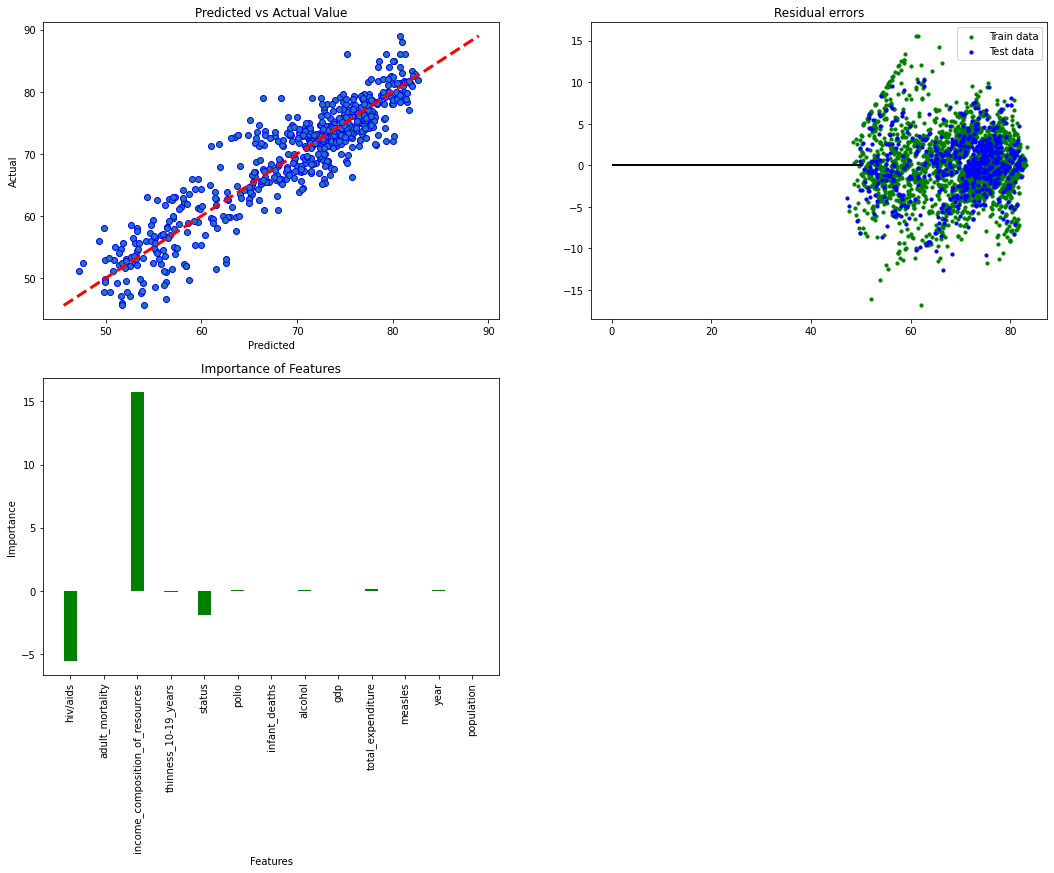




Bayesian Ridge Regression
-------------------------
Accuracy =  84.47131975474244
Mean Absolute Error =  2.7239773093722395
Mean Squared Error =  12.842127150277244




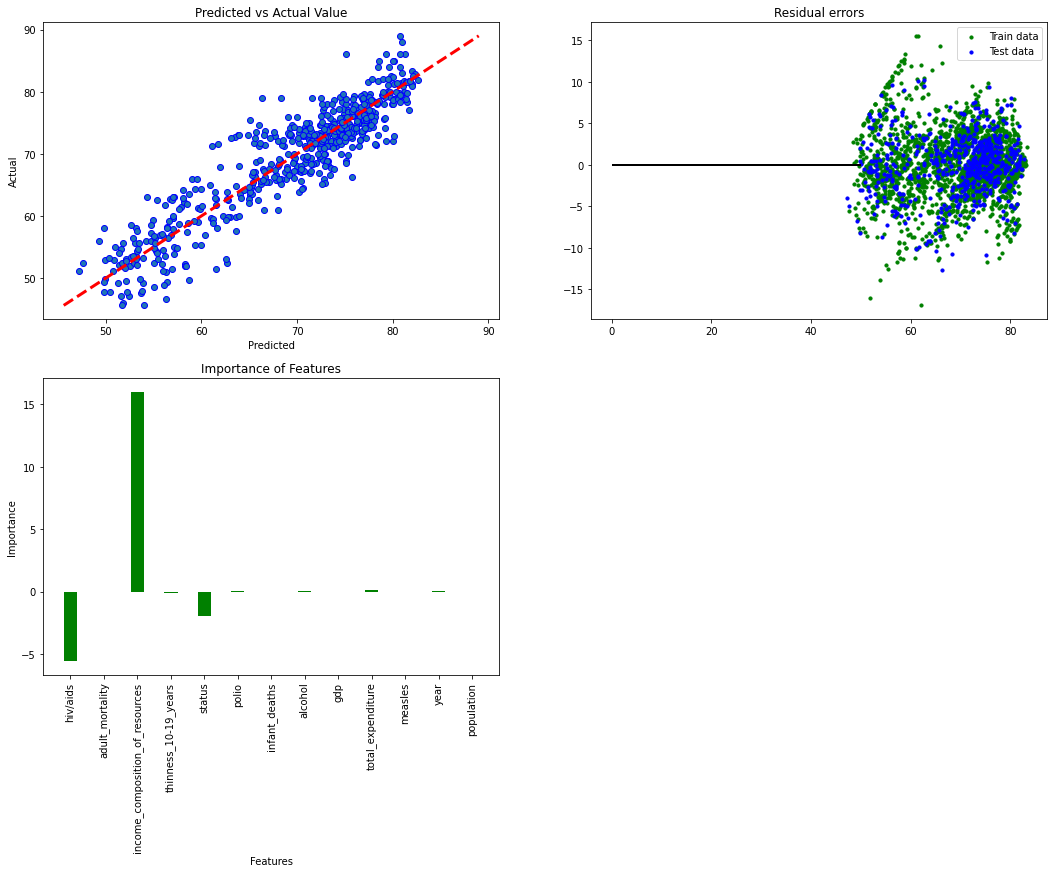

In [ ]:
#models = [Linear_reg, Random_forest, DT_reg, e_net, lasso, ridgeR, Bayreg, xgb_r]
models = [Random_forest, DT_reg, xgb_r,Linear_reg,lasso,e_net,ridgeR, Bayreg]
#model_names = ['Lnear Regression','Random Forest Regressor', 'Decision Tree Regressor', 'Elastic Net Regressor', 'Lasso Regression', 'Ridge Regression', 'Bayesian Ridge Regression', 'XGB Regressor']
model_names = ['Random Forest Regressor', 'Decision Tree Regressor', 'XGB Regressor','Lnear Regression','Lasso Regression','Elastic Net Regressor','Ridge Regression', 'Bayesian Ridge Regression']
i = 0
t = 0
Acc = []
Abs = []
Sqr = []
featureImp = [0,0,0,0,0,0,0,0,0,0,0,0,0]
for modelName in models:
  print(model_names[i])
  print("-"*len(model_names[i]))
  if i>2:
    t = 1
  i = i+1
  trainModel(modelName, Acc, Abs, Sqr,featureImp,t)

## **Accuracies of Models**

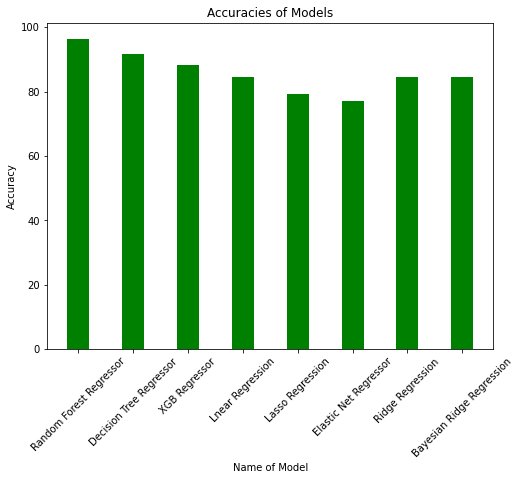

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(model_names, Acc,color='green', width = 0.4)
plt.xlabel("Name of Model")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Accuracies of Models")
plt.show()

## **Mean Absolute Error of Models**

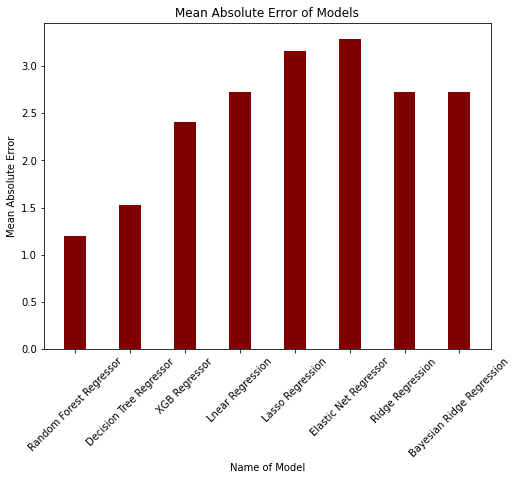

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(model_names, Abs, color ='maroon', width = 0.4)
plt.xlabel("Name of Model")
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error of Models")
plt.show()

## **Mean Squared Error of Models**

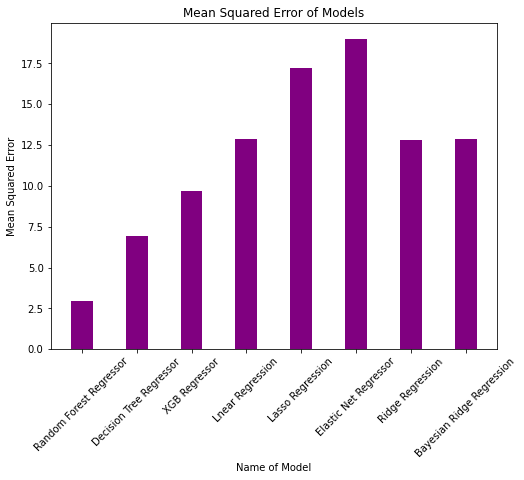

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(model_names, Sqr, color ='purple', width = 0.4)
plt.xlabel("Name of Model")
plt.xticks(rotation=45)
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error of Models")
plt.show()

## **Final Results**

In [ ]:
ModelTable = pd.DataFrame(
    {'Model Name': model_names,
     'Accuracy': Acc,
     'Mean Absolute Errors': Abs,
     'Mean Square Errors' : Sqr
    })

In [ ]:
print(tabulate(ModelTable, headers = 'keys', tablefmt = 'psql'))

+----+---------------------------+------------+------------------------+----------------------+
|    | Model Name                |   Accuracy |   Mean Absolute Errors |   Mean Square Errors |
|----+---------------------------+------------+------------------------+----------------------|
|  0 | Random Forest Regressor   |    96.4564 |                1.19972 |              2.93051 |
|  1 | Decision Tree Regressor   |    91.6507 |                1.53139 |              6.90485 |
|  2 | XGB Regressor             |    88.2729 |                2.40361 |              9.69824 |
|  3 | Lnear Regression          |    84.4359 |                2.72495 |             12.8714  |
|  4 | Lasso Regression          |    79.1759 |                3.15416 |             17.2214  |
|  5 | Elastic Net Regressor     |    77.0016 |                3.29121 |             19.0195  |
|  6 | Ridge Regression          |    84.4893 |                2.72376 |             12.8273  |
|  7 | Bayesian Ridge Regression |    84